# GSN: Generative Symbiotic Network

In [1]:
# packages used for machine learning
import tensorflow as tf

# packages used for processing: 
import matplotlib.pyplot as plt # for visualization
import numpy as np

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# import scipy image resize module
from scipy.misc import imresize

# to plot the images inline
%matplotlib inline

/home/animesh/Programming/Envs/deep_learning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '../..'])

Data
Error_analysis
LICENSE
Literature_survey
Models
README.md
Res
Scripts
Writeup_for_publication



In [55]:
''' Set the constants for the script '''

# various paths of the files
idea = "IDEA_5"
base_path = '.'
base_model_path = './Models'
graph_viz_path = "./graph_viz"

# constant values:
num_classes = 10
seed_value = 3
ndf = 64; ngf = ndf
class_lr = 2e-4
gen_lr = 2e-4

summary_checkpoint = 3

batch_size = 32
loss_threshold = 1e-12

In [5]:
np.random.seed(seed_value)
tf.set_random_seed(3)

In [6]:
# check the contents inside the data folder
exec_command(['ls', base_path])

graph_viz
gsn.ipynb
Models



In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# range normalize the data:
x_train = x_train / 255; x_test = x_test / 255

In [8]:
# print the shape information of the collected data
print("Training_data shapes:", x_train.shape, x_test.shape)
print("Test_data shapes:", x_test.shape, y_test.shape)

Training_data shapes: (50000, 32, 32, 3) (10000, 32, 32, 3)
Test_data shapes: (10000, 32, 32, 3) (10000, 1)


resize all the images to 64 x 64 size

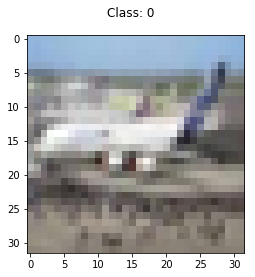

In [9]:
""" Run the cell again to see different output"""
# show a random image:
random_image_number = np.random.randint(len(x_train))
random_image = x_train[random_image_number]
label = y_train[random_image_number]
plt.figure().suptitle("Class: "+str(label[0]))
plt.imshow(random_image);

print a small slice of the data

In [10]:
print(x_train[33, :5, :5, 1])

[[0.01960784 0.01960784 0.01568627 0.01568627 0.01960784]
 [0.01568627 0.01568627 0.01176471 0.01568627 0.01176471]
 [0.00392157 0.02745098 0.03137255 0.03529412 0.06666667]
 [0.14901961 0.26666667 0.28627451 0.29019608 0.23921569]
 [0.34901961 0.42745098 0.44313725 0.43137255 0.3372549 ]]


randomly shuffle the test dataset to separate out a small fraction (2000 images) for validation

In [11]:
# function to perform synchronous random shuffling of the training data
def synch_random_shuffle_non_np(X, Y):
    '''
        ** This function takes in the parameters that are non numpy compliant dtypes such as list, tuple, etc.
        Although this function works on numpy arrays as well, this is not as performant enough
        @param
        X, Y => The data to be shuffled
        @return => The shuffled data
    '''
    combined = list(zip(X, Y))

    # shuffle the combined list in place
    np.random.shuffle(combined)

    # extract the data back from the combined list
    X[:], Y[:] = zip(*combined)

    # return the shuffled data:
    return X, Y

In [12]:
x_test, y_test = synch_random_shuffle_non_np(x_test, y_test)

In [13]:
# ensure the shapes are intact 
print("Test_data shapes:", x_test.shape, y_test.shape)

Test_data shapes: (10000, 32, 32, 3) (10000, 1)


In [14]:
# function to split the data into train - dev sets:
def split_train_dev(X, Y, train_percentage):
    '''
        function to split the given data into two small datasets (train - dev)
        @param
        X, Y => the data to be split
        (** Make sure the train dimension is the first one)
        train_percentage => the percentage which should be in the training set.
        (**this should be in 100% not decimal)
        @return => train_X, train_Y, test_X, test_Y
    '''
    m_examples = len(X)
    assert train_percentage < 100, "Train percentage cannot be greater than 100! NOOB!"
    partition_point = int((m_examples * (float(train_percentage) / 100)) + 0.5) # 0.5 is added for rounding

    # construct the train_X, train_Y, test_X, test_Y sets:
    train_X = X[: partition_point]; train_Y = Y[: partition_point]
    test_X  = X[partition_point: ]; test_Y  = Y[partition_point: ]

    assert len(train_X) + len(test_X) == m_examples, "Something wrong in X splitting"
    assert len(train_Y) + len(test_Y) == m_examples, "Something wrong in Y splitting"

    # return the constructed sets
    return train_X, train_Y, test_X, test_Y

In [15]:
x_test, y_test, x_valid, y_valid = split_train_dev(x_test, y_test, train_percentage=80)

In [16]:
print("Test (training) data shapes:", x_test.shape, y_test.shape)
print("Validation data shapes:", x_valid.shape, y_valid.shape)

Test (training) data shapes: (8000, 32, 32, 3) (8000, 1)
Validation data shapes: (2000, 32, 32, 3) (2000, 1)


Alright! it is quite good till now...

### Let's define the network now ... 

In [32]:
tf.reset_default_graph()

In [33]:
# The classifier network:
def classifier_network(x, batch_norm_mode, variable_reuse=False):
    """ define the network computations pipeline for the input.
        @args
            x: input to the network computations
            batch_norm_mode: tensor for notifying the batch_norm mode
        @return
            None
            (adds the ops to the current graph in scope)
    """

    with tf.variable_scope("Classifier_Network", reuse=variable_reuse):
        # block 1
        x = tf.layers.conv2d(x, filters=ndf, kernel_size=4, strides=2, padding="same", use_bias=False,
                            name="conv_1")
        x = tf.nn.leaky_relu(x, alpha=0.2)

        # block 2
        x = tf.layers.conv2d(x, filters=ndf*2, kernel_size=4, strides=2, padding="same", use_bias=False,
                            name="conv_2")
        x = tf.layers.batch_normalization(x, training=batch_norm_mode,
                                         name="bn_1")
        x = tf.nn.leaky_relu(x, alpha=0.2)

        # block 3
        x = tf.layers.conv2d(x, filters=ndf*4, kernel_size=4, strides=2, padding="same", use_bias=False,
                            name="conv_3")
        x = tf.layers.batch_normalization(x, training=batch_norm_mode,
                                         name="bn_2")
        x = tf.nn.leaky_relu(x, alpha=0.2)

        # final block
        x = tf.layers.conv2d(x, filters=ndf*8, kernel_size=4, strides=1, padding="valid", use_bias=False,
                            name="conv_4")
        x = tf.squeeze(x, axis=(1, 2))
    
    return x

Define the inputs to the graph:

In [34]:
with tf.name_scope("Inputs"):
    x_input = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name="input_x")    
    tf.summary.image("Input_Images", x_input)    
    bn_train_mode = tf.placeholder(tf.bool, shape=(), name="batch_norm_mode")
    y_label = tf.placeholder(tf.int32, shape=(None, 1), name="input_labels")

Define the one hot encoder for the input labels

In [35]:
with tf.variable_scope("One_Hot_Encoder"):
    y_encoded = tf.one_hot(y_label, depth=num_classes, name="one_hot_encode")
    
print("Encoded_Labels: ", y_encoded.shape)

Encoded_Labels:  (?, 1, 10)


Define the classifer output:

In [36]:
clas_op = classifier_network(x_input, bn_train_mode)
print("Classifier_Network_Output_shape: ", clas_op.shape)

Classifier_Network_Output_shape:  (?, 512)


In [37]:
classifier_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="Classifier_Network")
for var in classifier_variables:
    tf.summary.histogram(var.name.split(':')[0], var)
    print(var.name, var.shape)

Classifier_Network/conv_1/kernel:0 (4, 4, 3, 64)
Classifier_Network/conv_2/kernel:0 (4, 4, 64, 128)
Classifier_Network/bn_1/gamma:0 (128,)
Classifier_Network/bn_1/beta:0 (128,)
Classifier_Network/conv_3/kernel:0 (4, 4, 128, 256)
Classifier_Network/bn_2/gamma:0 (256,)
Classifier_Network/bn_2/beta:0 (256,)
Classifier_Network/conv_4/kernel:0 (4, 4, 256, 512)


In [38]:
# classifier connection dense layer:
def dense_classifier(x, variable_reuse=False):
    with tf.variable_scope("Dense_Classifier", reuse=variable_reuse):
        raw_preds = tf.layers.dense(x, activation=tf.nn.relu,
                                    units=num_classes, name="final_classification_layer")

        predictions = tf.nn.softmax(raw_preds)
    
    return raw_preds, predictions

In [39]:
raw_preds, predictions = dense_classifier(clas_op)

In [40]:
fdc_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="Dense_Classifier")
for var in fdc_variables:
    tf.summary.histogram(var.name.split(':')[0], var)
    print(var.name, var.shape)

Dense_Classifier/final_classification_layer/kernel:0 (512, 10)
Dense_Classifier/final_classification_layer/bias:0 (10,)


In [41]:
# The generator network
def generator_network(x, batch_norm_mode):
    """ define the network computations pipeline for the input.
        @args
            x: input to the network computations
            batch_norm_mode: tensor for notifying the batch_norm mode
        @return
            None
            (adds the ops to the current graph in scope)
    """

    with tf.variable_scope("Generator_Network"):
        # block 1
        x = tf.layers.conv2d_transpose(x, filters=ndf*4, kernel_size=4, strides=2, padding="valid", use_bias=False,
                            name="conv_1_transpose")
        x = tf.layers.batch_normalization(x, training=batch_norm_mode, name="bn_1")
        x = tf.nn.relu(x)
        
        # block 2
        x = tf.layers.conv2d_transpose(x, filters=ndf*2, kernel_size=4, strides=2, padding="same", use_bias=False,
                            name="conv_2_transpose")
        x = tf.layers.batch_normalization(x, training=batch_norm_mode, name="bn_2")
        x = tf.nn.relu(x)
        
        # block 3
        x = tf.layers.conv2d_transpose(x, filters=ndf, kernel_size=4, strides=2, padding="same", use_bias=False,
                            name="conv_3_transpose")
        x = tf.layers.batch_normalization(x, training=batch_norm_mode, name="bn_3")
        x = tf.nn.relu(x)

        # final block 
        x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=4, strides=2, padding="same", use_bias=False,
                            name="conv_4_transpose")
        x = tf.nn.sigmoid(x)
    
    return x

In [42]:
with tf.variable_scope("Pipe"):
    bt_size = tf.shape(clas_op)[0]
    noise = tf.random_normal(shape=(bt_size, 128), name="random_noise")
    generator_in = tf.concat([clas_op, noise], axis=-1, name="conditional_output_with_noise")
    generator_in = tf.expand_dims(tf.expand_dims(generator_in, axis=1, name="expand_dim_1"), 
                                  axis=1, name="expand_dim_2")

In [43]:
print("Generator_Network_input_shape:", generator_in)

Generator_Network_input_shape: Tensor("Pipe/expand_dim_2:0", shape=(?, 1, 1, 640), dtype=float32)


In [44]:
generator_out = generator_network(generator_in, bn_train_mode)
tf.summary.image("Generated_Images", generator_out)
print("Generator_Network_output_shape:", generator_out.shape)

Generator_Network_output_shape: (?, 32, 32, 3)


In [45]:
generator_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="Generator_Network")
for var in generator_variables:
    tf.summary.histogram(var.name.split(':')[0], var)
    print(var.name, var.shape)

Generator_Network/conv_1_transpose/kernel:0 (4, 4, 256, 640)
Generator_Network/bn_1/gamma:0 (256,)
Generator_Network/bn_1/beta:0 (256,)
Generator_Network/conv_2_transpose/kernel:0 (4, 4, 128, 256)
Generator_Network/bn_2/gamma:0 (128,)
Generator_Network/bn_2/beta:0 (128,)
Generator_Network/conv_3_transpose/kernel:0 (4, 4, 64, 128)
Generator_Network/bn_3/gamma:0 (64,)
Generator_Network/bn_3/beta:0 (64,)
Generator_Network/conv_4_transpose/kernel:0 (4, 4, 3, 64)


In [46]:
print("Predictions_output:", predictions.shape)

Predictions_output: (?, 10)


In [47]:
with tf.name_scope("Losses"):
    with tf.name_scope("classifier_loss"):
        class_loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=raw_preds, labels=y_encoded))
    
        tf.summary.scalar("classifier_loss", class_loss)
    
    with tf.name_scope("generator_loss"):
        gen_loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=dense_classifier(
                        classifier_network(generator_out, bn_train_mode, variable_reuse=True),
                        variable_reuse=True
                   )[0],
            labels=y_encoded))
        
        tf.summary.scalar("generator_loss", gen_loss)

In [48]:
with tf.name_scope("Accuracy"):
    correct_vals = tf.cast(tf.equal(tf.argmax(predictions, axis=-1, output_type=tf.int32), y_label), tf.float32)
    accuracy = tf.reduce_mean(correct_vals, name="accuracy")
    tf.summary.scalar("Accuracy", accuracy)

In [49]:
with tf.name_scope("Optimizers"):
    with tf.name_scope("classifier_optimizer"):
        classifier_optimizer = tf.train.AdamOptimizer(learning_rate=class_lr).minimize(class_loss, 
                                                    var_list=classifier_variables + fdc_variables, name="clas_op")
    
    with tf.name_scope("generator_optimizer"):
        generator_optimizer = tf.train.AdamOptimizer(learning_rate=gen_lr).minimize(gen_loss,
                                                    var_list=generator_variables, name="gen_op")

In [50]:
with tf.name_scope("Errands"):
    init = tf.global_variables_initializer()
    all_summaries = tf.summary.merge_all()

### Before starting the training, check the graph in Tensorboard

run the following cell. This generates an events file in the `./graphviz/` directory. Run tensorboard inside that directory to visualize the graph structure prior to running the training session

In [51]:
# save the graph to check the structure
tensorboard_writer = tf.summary.FileWriter(logdir=graph_viz_path, 
                                           graph=tf.get_default_graph(), filename_suffix=".bot")

# delete this writer. I will create another one while training the network
del tensorboard_writer

### Now, I can run the training of the network 

In [52]:
model_name = "Model_2"

In [53]:
model_save_path = os.path.join(base_model_path, model_name)
print("Model save path: ", model_save_path)

Model save path:  ./Models/Model_2


In [54]:
total_train_samples = len(x_test)
print("total training exaples:", total_train_samples)

total training exaples: 8000


In [ ]:
""" Training cell for the network """

with tf.Session() as sess:
    # create a tensorboard writer
    tensorboard_writer = tf.summary.FileWriter(logdir=model_save_path, graph=sess.graph, filename_suffix=".bot")
    
    # create a saver
    saver = tf.train.Saver(max_to_keep=2)
    
    # restore the session if the checkpoint exists:
    if(os.path.isfile(os.path.join(model_save_path, "checkpoint"))):
        saver.restore(sess, tf.train.latest_checkpoint(model_save_path))
    
    else: # initialize all the variables:
        sess.run(init)
        
    loss_delta = float('inf'); prev_loss = 0
    
    global_step = 0
    epoch = 0
    # start the training loop ... 
    while loss_delta >= loss_threshold:
        # run the training
        no_of_batches = int(np.ceil(total_train_samples / batch_size))
        gen_x, gen_y = None, None # start with empty lists
        
        cls_loss = []; cls_accuracy = []
        gen_loss = [];
        
        for bat_no in range(no_of_batches):
            # extract the data for training
            start = bat_no * batch_size; end = start + batch_size
            
            batch_x = x_test[start: end]; batch_y = y_test[start: end]
            
            # append the generated data
            if gen_x is not None and gen_y is not None:
                app_batch_x = np.concatenate([batch_x, gen_x], axis=0)
                app_batch_y = np.concatenate([batch_y, gen_y], axis=0)
            else:
                app_batch_x = batch_x
                app_batch_y = batch_y
        
            #==================================================================
            # Classifier training
            #==================================================================
            # run the classification training step
            _, cls_ls, cls_acc = sess.run([classifier_optimizer, class_loss, accuracy],
                                      feed_dict={
                                          x_input: app_batch_x,
                                          y_label: app_batch_y,
                                          bn_train_mode: True
                                      })
            
            #==================================================================
            # Generator training
            #==================================================================
            # run the generator training step
            _, gen_ls, gen_imgs = sess.run([generator_optimizer, 
                                                           gen_loss, generator_out],
                                                      feed_dict={
                                                          x_input: batch_x,
                                                          y_label: batch_y,
                                                          bn_train_mode: True
                                                      })
            
            # fill the gen_x and gen_y batches:
            idx = np.random.randint(batch_size, size=int(batch_size / 2))
            gen_x = gen_imgs[idx]; gen_y = batch_y[idx]
            
            cls_loss.append(cls_ls); cls_accuracy.append(cls_acc)
            gen_loss.append(gen_ls)
        
            if bat_no == 0 or (bat_no + 1) % summary_checkpoint == 0:
                # this includes all the summaries
                sums = sess.run(all_summaries, feed_dict={
                                                    x_input: batch_x,
                                                    y_label: batch_y,
                                                    bn_train_mode: True
                                                })
                tensorboard_writer.add_summary(sums, global_step=global_step)
                
            global_step += 1
        
        current_loss = np.mean(cls_loss)
        loss_delta = np.abs(current_loss - prev_loss)
        prev_loss = current_loss
        
        # print all the summary
        print("Classification_Loss: %.3f Classification_Accuracy: %.3f" %(current_loss, np.mean(cls_accuracy)))
        print("Generation_Loss: %.3f" %(np.mean(gen_loss)))
        
        epoch += 1
        
        if epoch == 1 or epoch % summary_checkpoint == 0:
            graph_save_status = (epoch == 1)
            saver.save(sess, save_path=os.path.join(model_save_path, model_name), 
                       global_step=epoch, write_meta_graph=graph_save_status)

# Assess the results now ....